# Detecção de retas e círculos com a Transformada de Hough

A **Transformada de Hough** é uma metodologia capaz de fazer a detecção de objetos baseados em figuras geométricas ou em uma nuvem de pontos. O OpenCV implementa a Transformada de Hough para a detecção de lihas retas e círculos. 

## Detecção de retas

Para detectar as retas, a transformada de Hough levanta todas as possíveis retas que passam por um determinado ponto de borda, representadas por seus parâmetros $\rho$ e $\theta$. Os parâmetros dessas retas recebem um voto em uma *matriz de votação*, ou *acumulador*. Quanto mais pontos uma determinada reta pode cruzar, mais votos seus parãmetros receberão.

Vamos analisar a matriz de votação resultante das imagens abaixo


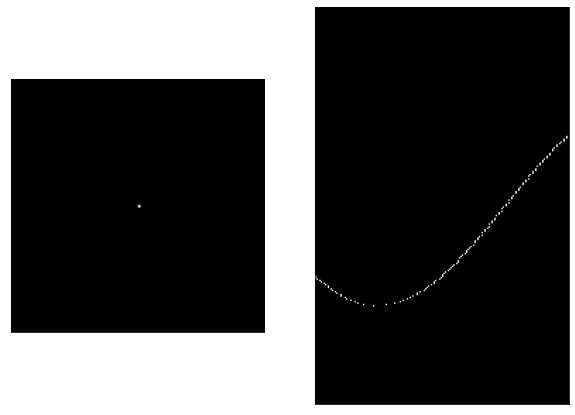

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from hough_helper import mostra_imagem
from hough_helper import acumulador_hough_retas

# Imagem com apenas um ponto
h = 100
w = 100
img1 = np.zeros((h, w), dtype=np.uint8)
img1[h//2, w//2] = 255
votes1 = acumulador_hough_retas(img1, 1, np.pi/180) 
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
mostra_imagem(img1, subfig=True)
plt.subplot(1, 2, 2)
mostra_imagem(votes1)

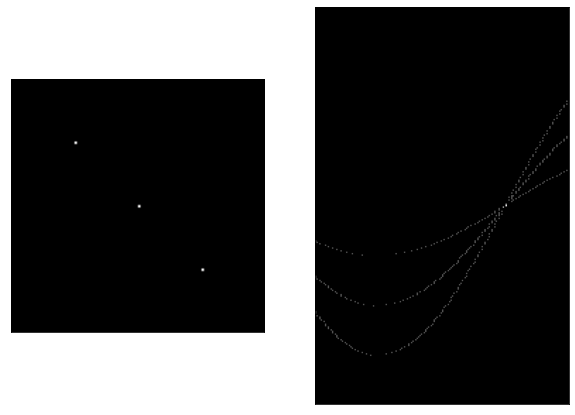

In [3]:
# Imagem com três pontos colineares
img2 = np.zeros((h, w), dtype=np.uint8)
img2[h//4, w//4] = 255
img2[h//2, w//2] = 255
img2[3*h//4, 3*w//4] = 255

votes2 = acumulador_hough_retas(img2, 1, np.pi/180) 

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
mostra_imagem(img2, subfig=True)
plt.subplot(1, 2, 2)
mostra_imagem(votes2)

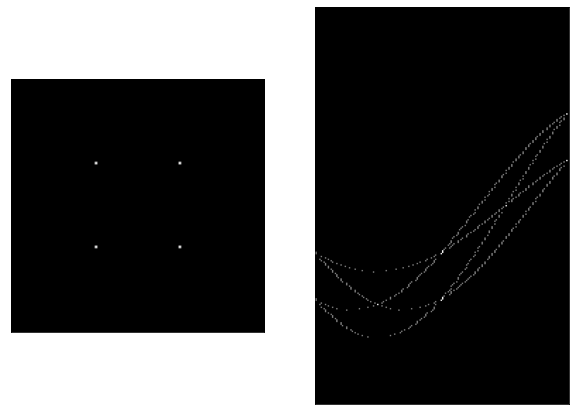

In [4]:
# Imagem com quatro pontos (retângulo)
img3 = np.zeros((h, w), dtype=np.uint8)
img3[h//3, w//3] = 255
img3[2*h//3, w//3] = 255
img3[h//3, 2*w//3] = 255
img3[2*h//3, 2*w//3] = 255
votes3 = acumulador_hough_retas(img3, 1, np.pi/180) 

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
mostra_imagem(img3, subfig=True)
plt.subplot(1, 2, 2)
mostra_imagem(votes3)

## Usando a Hough Transform para retas

### Primeiro, encontrar os pontos de borda

Por exemplo, com o método de Canny

In [15]:
import cv2
import auxiliar as aux
from hough_helper import mostra_imagem

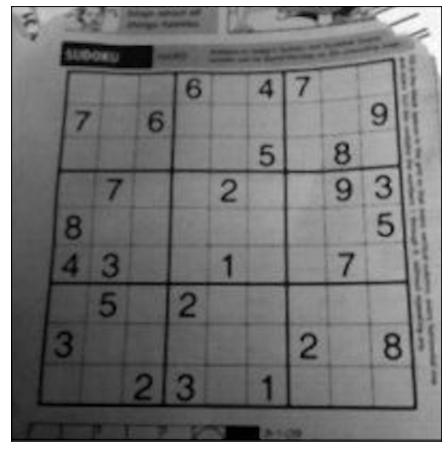

In [16]:
img = cv2.imread('dave.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8,8))
mostra_imagem(img)

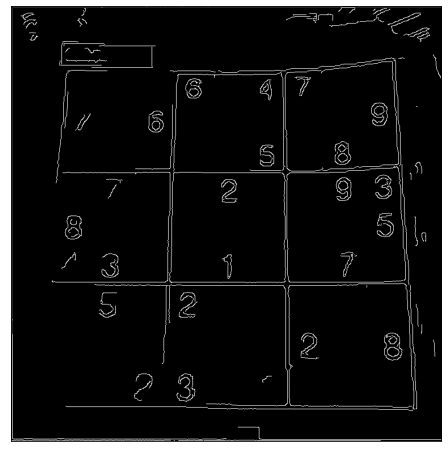

In [17]:
bordas = aux.auto_canny(img)
plt.figure(figsize=(8,8))
mostra_imagem(bordas)

## Uso da função HoughLines


O uso básico da função para a detecção de retas com a Transformada de Hough é:

    lines = cv2.HoughLines( image, rho, theta, threshold )
    

- `image`: Imagem de 8 bits contendo os pontos de borda na cor branca
- `lines`: Matriz de saída das linhas detectadas. Cada linha da matriz contém 2 elementos (ρ,θ):
    + `ρ` é a distancia da reta à origem das coordenadas (0,0)
    + `θ` é o ângulo da reta
- `rho`: Resolução da distância em pixels. 1 pixel está OK.
- `theta`: Resolução do ângulo em radiandos. 1 grau está OK.
- `threshold`: Limiar de detecção da reta. São retornadas apenas aquelas retas com número suficiente de votos (>`threshold`).

Vejamos o exemplo com a imagem de bordas acima














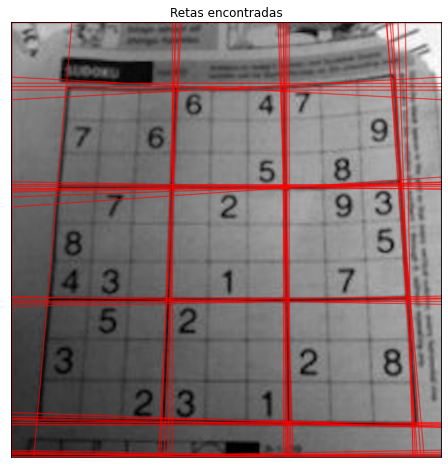

In [20]:
from hough_helper import desenha_retas

lines = cv2.HoughLines(bordas, 1, np.pi/180, 100) 
img_retas = desenha_retas(img, lines)

plt.figure(figsize=(8,8))
mostra_imagem(img_retas, "Retas encontradas")


Podemos aplicar a técnica de *Non-Maximum Suppression*, ou seja, se encontrarmos uma boa reta $(\rho, \theta)$, descartamos as próximas que tenham parâmetros parecidos 

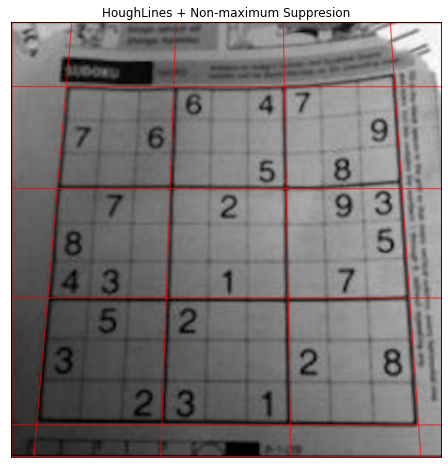

In [36]:
import math

rho_interval = 40 #pixels
theta_interval = math.radians(20) # graus

good_lines = []
for line in lines:
    candidate = True
    rho, theta= line[0]
        
    for good_line in good_lines:
        rho2, theta2 = good_line[0]
        if abs(abs(rho2)-abs(rho)) < rho_interval and min(abs(theta-theta2),abs(abs(theta-theta2)-math.pi) ) < theta_interval:
            candidate = False
            break
    if candidate:
        good_lines.append([[rho, theta]])
        
img_retas = desenha_retas(img, good_lines)  

plt.figure(figsize=(8,8))
mostra_imagem(img_retas, "HoughLines + Non-maximum Suppresion")

## A função HoughLinesP

É uma implementação eficiente da função HoughLines ([ver explicação](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)). Em vez de retornar os parâmetros da treta, retorna uma lista de segmentos de reta identificados pelos pontos inicial e final.


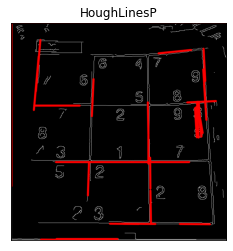

In [46]:
50
lines = cv2.HoughLinesP(bordas, 10, math.pi/180.0, threshold=100, minLineLength=100, maxLineGap=30)

a,b,c = lines.shape

hough_img_rgb = cv2.cvtColor(bordas, cv2.COLOR_GRAY2BGR)

for i in range(a):
    # Faz uma linha ligando o ponto inicial ao ponto final, com a cor vermelha (BGR)
    cv2.line(hough_img_rgb, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 5, cv2.LINE_AA)
    
mostra_imagem(hough_img_rgb, "HoughLinesP")

## Encontrando circunferências na imagem

A implementação da transformada de Hough para encontrar circunferências emprega algumas otimizações que tornam desnecessário encontrar as bordas da imagem antes. No entanto, se usarmos a imagem resultante da magnitude do gradiente, teremos um melhor resultado, pois as bordas estarão mais detacadas. Outras melhorias que podemos aplicar antes do realce das bordas são:

- Leve redução do contraste para equilibrar a iluminação na imagem
- Uso do filtro da mediana para atenuação de ruído

O uso básico da função para a detecção de circunferências com a Transformada de Hough é:
    
    circles = cv2.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius)

- `image`: Imagem de 8 bits onde as circunferências serão procuradas
- `method`: método usado para encontrar os possíveis centros de cada circunferência. Aqui vamos usar `cv2.HOUGH_GRADIENT`.
- `dp`: resolução usada na procura pelos centros das circunferências
- `minDist`: menor distância permitida entre os centros das circunferências encontradas
- `param1`: limiar empregado na detecção dos pontos de borda
- `param2`: limiar de detecção da circunferência
- `minRadius`: menor raio da circunferência a ser encontradas
- `maxRadius`: maior raio da circunferência a ser encontradas

Veja o exemplo do uso da função na imagem das bordas realçadas acima


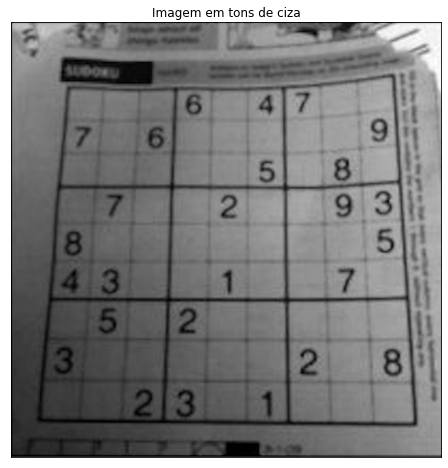

In [49]:
plt.figure(figsize=(8,8))
mostra_imagem(img, "Imagem em tons de ciza")


In [122]:
circles = cv2.HoughCircles(img, method=cv2.HOUGH_GRADIENT, dp=1, minDist=12, param1=40, param2=13, minRadius=10, maxRadius=14)

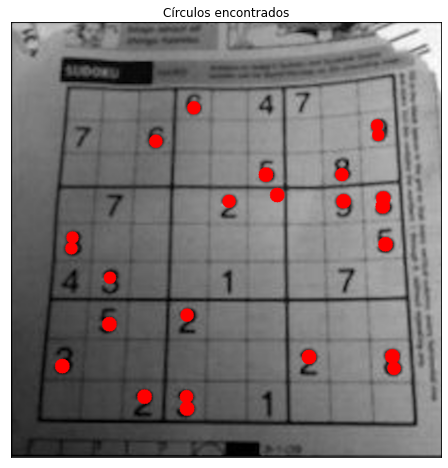

In [123]:
img_circles = desenha_circulos(img, circles)
plt.figure(figsize=(8,8))
mostra_imagem(img_circles, "Círculos encontrados")